In [18]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
DATA_PATH = '../data/features/'

tran = pd.read_csv(DATA_PATH + "T.csv")
tran = tran.set_index(['ID', 'copy_num'])

ntran = pd.read_csv(DATA_PATH + "NT.csv")
ntran = ntran.set_index(['ID', 'copy_num'])


In [3]:
SALT2_PATH = './chi2Salt2/'

tsalt  = pd.read_csv(SALT2_PATH + 'transient/allTransient.dat'      , names = ['ID', 'copy_num','chi2Salt2'],delimiter=' ')
ntsalt = pd.read_csv(SALT2_PATH + 'nonTransient/allNonTransient.dat', names = ['ID', 'copy_num','chi2Salt2'],delimiter=' ')

tsalt = tsalt.set_index(['ID', 'copy_num'])
ntsalt = ntsalt.set_index(['ID', 'copy_num'])


In [4]:
print('Original')
print('transients',tran.shape)
print('non transients',ntran.shape)

Original
transients (46959, 34)
non transients (15193, 34)


In [5]:
tran = tran.join(tsalt, how='inner')
ntran = ntran.join(ntsalt, how='inner')

In [6]:
print('SALT2')
print('transients',tran.shape)
print('non transients',ntran.shape)

SALT2
transients (40573, 35)
non transients (14084, 35)


In [7]:
print("Total amout of obects (oversampled):     {}".format(tran.shape[0]+ntran.shape[0]))
print("Total amout of obects (not oversampled): {}".format(tran[tran.index.get_level_values("copy_num")==0].shape[0]+ntran.shape[0]))

Total amout of obects (oversampled):     54657
Total amout of obects (not oversampled): 18353


In [8]:
#remove unwanted columns
unwanted = [
    'poly3_t3',
    'poly3_t2',
    'poly3_t1',
    'poly4_t1',
    'poly4_t2',
    'poly4_t3',
    'poly4_t4',
    'chi2SALT2',
    ]    

tran  =  tran.drop(unwanted,axis=1)
ntran = ntran.drop(unwanted,axis=1)

In [9]:
#reorder for easy feature selection
# tran = tran[:-3]+tran[-1:]+tran[:-3]+tran[-3:-1]
# ntran = ntran[:-3]+ntran[-1:]+ntran[:-3]+ntran[-3:-1]
def totFeats():
    feats = np.array(list(tran.columns[:-3])+[tran.columns[-1]])
    return feats
feats = totFeats()
print("Total number of features: {}".format(len(feats)))
print()
print("The features are:")
for i,f in enumerate(feats):
    print("    "+str(i+1)+". " + f)


Total number of features: 25

The features are:
    1. skew
    2. std
    3. kurtosis
    4. beyond1st
    5. stetson_j
    6. stetson_k
    7. max_slope
    8. amplitude
    9. median_absolute_deviation
    10. median_buffer_range_percentage
    11. pair_slope_trend
    12. percent_amplitude
    13. percent_difference_flux_percentile
    14. flux_percentile_ratio_mid20
    15. flux_percentile_ratio_mid35
    16. flux_percentile_ratio_mid50
    17. flux_percentile_ratio_mid65
    18. flux_percentile_ratio_mid80
    19. small_kurtosis
    20. pair_slope_trend_last_30
    21. poly1_t1
    22. poly2_t2
    23. poly2_t1
    24. chi2sGauss
    25. chi2Salt2


# Binary Classification 
Transients and non-transients 

In [10]:
def splitTrainTest(dataframe):
    #create output dataframes
    test = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    test = test.set_index(["ID","copy_num"])

    train = pd.DataFrame(columns = ["ID","copy_num"]+list(dataframe.columns))
    train = train.set_index(["ID","copy_num"])
    
    for uClass in dataframe.Class.unique():
        #get each class 
        classDf = dataframe[dataframe.Class == uClass]
        
        #unique ids
        ids = classDf.index.get_level_values('ID').unique()

        # randomly choose 25% of indices 

        testInd = np.random.choice(ids, int(0.25*len(ids)),replace=False)

        #get dataframes
        test = pd.concat([test,classDf[classDf.index.get_level_values('ID').isin(testInd)]])
        
        train = pd.concat([train,classDf[~classDf.index.get_level_values('ID').isin(testInd)]])

    return train,test


In [24]:
def balance(df):
    #start min at infinity 
    minNum = np.inf
    nameMin = ""
    #find the class with the minimum amount of candidates
    for classElem in df.Class.unique():
        numElems = len(df[df.Class==classElem])
        if(numElems<minNum):
            minNum=numElems
            nameMin = classElem
    print("The class with least elements is:")
    print(classElem, minNum)
    #create output dataframe
    ans = pd.DataFrame(columns = ["ID","copy_num"]+list(df.columns))
    ans = ans.set_index(["ID","copy_num"])
    
    #get a sample from all the classes 
    for classElem in df.Class.unique():
        ans = pd.concat([ans,df[df.Class==classElem].sample(n=minNum)])
        
    return ans

In [12]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [13]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly2_t1',
      'poly2_t1':'poly1_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4', 
      'chi2sGauss':'chi2sGauss',
      'chi2Salt2':'chi2SALT2'
      }[x]

In [14]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [15]:
#copy and shuffle the data
alldf = pd.concat([tran,ntran])
oversampling = alldf.copy()
oversampling = oversampling.sample(frac=1)

#map all objects that are not non-transient to transient
oversampling.Class = list(map(lambda x: 'SN' if x=='SN' else 'NSN', oversampling.Class))
#map transient and non-transient to binary values
oversampling['target'] = list(map(lambda x: 1 if x=='SN' else 0, oversampling.Class))

In [22]:
def getData():
    #split train test class by class
    all_train,all_test = splitTrainTest(oversampling)
    print('Before balancing')
    print(all_train.shape)
    #balance the train set
    
    all_train= balance(all_train)
    print('After balancing')
    print(all_train.shape)
    #train indices
    trainIdx = all_train.index.get_level_values("ID").unique()

    #remove originals that have oversampled copies in train
    all_test = all_test[~all_test.index.get_level_values("ID").isin(trainIdx)]

    #remove oversampled data from test set
    all_test = all_test[all_test.index.get_level_values('copy_num') ==0 ]


    #format target variable to appropriate data type
    all_train.target= all_train.target.astype('int')
    all_test.target= all_test.target.astype('int')

    print("SN in test set:")
    print(len(all_test[all_test.Class=='SN']))
    print("NSN in test set:")
    print(len(all_test[all_test.Class!='SN']))
    return all_train, all_test

In [25]:
all_train, all_test = getData()

Before balancing
(41206, 28)
The class with least elements is:
SN 9293
After balancing
(18586, 28)
SN in test set:
323
NSN in test set:
4265


In [19]:

pickle.dump( all_train, open( "./chi2Salt2/stableData/allTrain.pkl", "wb" ) )
pickle.dump( all_test, open( "./chi2Salt2/stableData/allTest.pkl", "wb" ) )

In [21]:
all_train.shape

(18658, 28)

In [17]:
def trainModel(feats):
    #learning 
    recall_scores = []
    model,params = rf()
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                               refit='f1_score', return_train_score=True,verbose=100)
    grid_search.fit(all_train[feats], all_train.target)

    # Copy classifier 
    clf = grid_search

    #see performance on test set
    scores = precision_recall_fscore_support(
            all_test.target, clf.predict(all_test[feats]), average='weighted')
    recall_scores.append(scores)
    
    recall_scoresnp = np.array(recall_scores)

    print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
    print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
    print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))
    recall_scoresnp = np.array(recall_scores)

    print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
    print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
    print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))
    return clf

In [18]:
def plotImportances(clf,feats): 
    #calculate feature importance in descending order
    importances = clf.best_estimator_.feature_importances_*100
    featsCopy = feats.copy()
    # print(featsCopy)
    Y = list(importances)
    X = list(featsCopy)

    yx = list(zip(Y, X))
    yx.sort()

    yx = yx[::-1]

    x_sorted = [x for y, x in yx]
    y_sorted = [y for y, x in yx]
    #shorten name length
    for i,x in enumerate(x_sorted):
        x_sorted[i]=shorten(x)
    # print(x_sorted)
    plt.rcParams["font.family"] = "Times New Roman"
    fig = plt.figure(figsize=(14,8))
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
    plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Feature importance(%)')
    plt.title("Binary Classification")

In [19]:
def calculateCM(clf):    
    cm = confusion_matrix(all_test.target, clf.predict(all_test[feats])).transpose()

    precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
    recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
    precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
    recallT = cm[1][1]/(cm[1][1]+cm[0][1])

    print("Precision of SN:     {:.4f}".format(precisionT))
    print("Recall of SN:        {:.4f}".format(recallT))
    print("F-measure of SN:     {:.4f}".format(fMeasure(precisionT,recallT)))
    print("Precision of NSN: {:.4f}".format(precisionNon))
    print("Recall of NSN:    {:.4f}".format(recallNon))
    print("F-measure of NSN: {:.4f}".format(fMeasure(precisionNon,recallNon)))


In [20]:
def runModel(feats):
    clf  = trainModel(feats)
    plotImportances(clf,feats)
    calculateCM(clf)

In [25]:
clf  = trainModel(feats)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8815648445873526, precision=0.8832245337543294, recall=0.8815648445873526, f1_score=0.8814364742835895, total=   6.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8736063464837049, precision=0.8754293093110905, recall=0.8736063464837049, f1_score=0.8734527283681434, total=   6.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.879957127545552, precision=0.8816863970482508, recall=0.879957127545552, f1_score=0.8798210067212646, total=  24.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


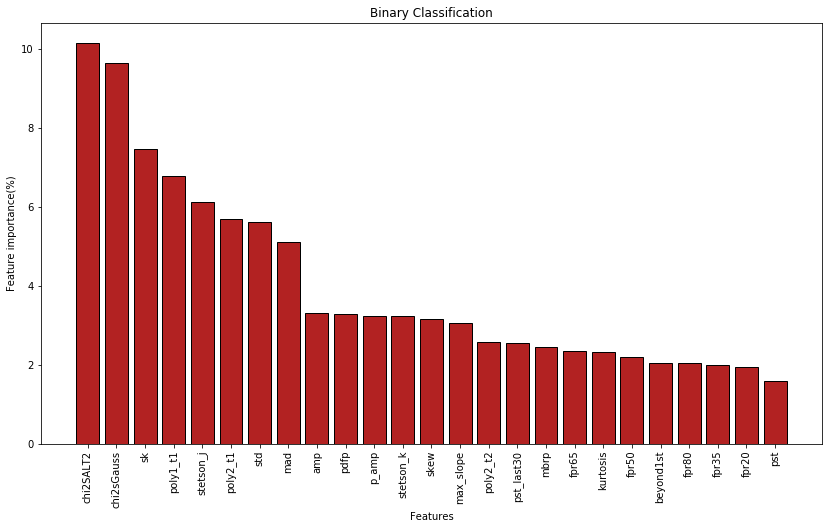

In [26]:
plotImportances(clf,feats)

In [27]:
calculateCM(clf)

Precision of SN:     0.3899
Recall of SN:        0.6904
F-measure of SN:     0.4983
Precision of NSN: 0.9751
Recall of NSN:    0.9182
F-measure of NSN: 0.9458


# Without using chi2s

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8572347266881029, precision=0.85854492943476, recall=0.8572347266881029, f1_score=0.8571041834311884, total=   6.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8481989708404802, precision=0.8497843846256864, recall=0.8481989708404802, f1_score=0.8480267644232874, total=   8.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.8568060021436227, precision=0.858347860121395, recall=0.8568060021436227, f1_score=0.8566518066117308, total=  35.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


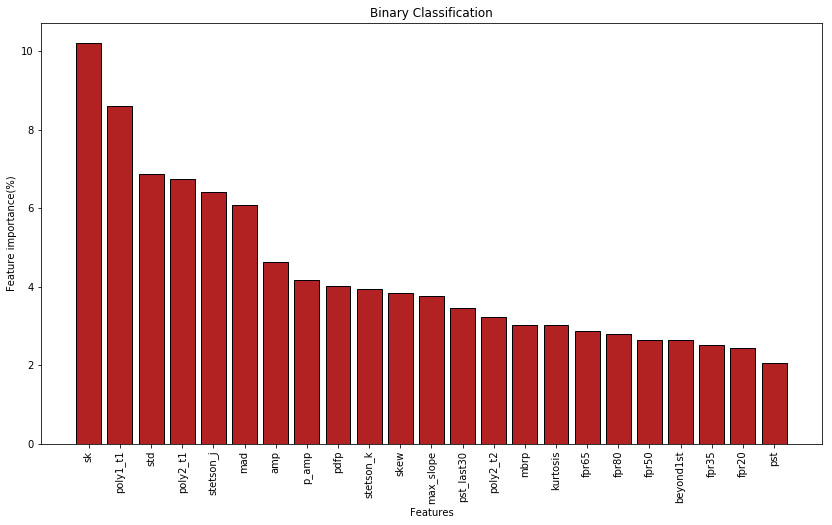

In [40]:
feats = totFeats()[:-2]
runModel(feats)

## Only skewGaussian

['skew' 'std' 'kurtosis' 'beyond1st' 'stetson_j' 'stetson_k' 'max_slope'
 'amplitude' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'percent_amplitude'
 'percent_difference_flux_percentile' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80'
 'small_kurtosis' 'pair_slope_trend_last_30' 'poly1_t1' 'poly2_t2'
 'poly2_t1' 'chi2sGauss']
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8697749196141479, precision=0.8714044436026014, recall=0.8697749196141479, f1_score=0.8696319232714702, total=   5.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8632075471698113, prec

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


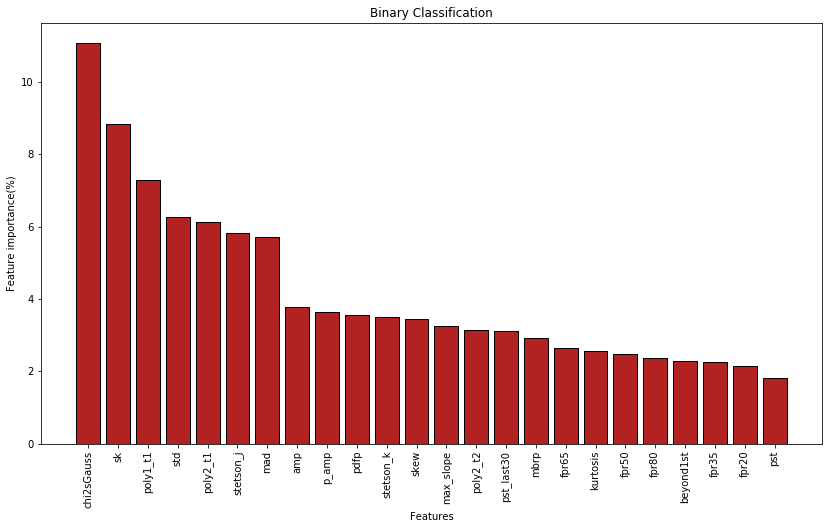

In [37]:
feats= totFeats()[:-1]
print(feats)
runModel(feats)

## salt2

In [35]:
feats = totFeats()

In [36]:
feats

array(['skew', 'std', 'kurtosis', 'beyond1st', 'stetson_j', 'stetson_k',
       'max_slope', 'amplitude', 'median_absolute_deviation',
       'median_buffer_range_percentage', 'pair_slope_trend',
       'percent_amplitude', 'percent_difference_flux_percentile',
       'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35',
       'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65',
       'flux_percentile_ratio_mid80', 'small_kurtosis',
       'pair_slope_trend_last_30', 'poly1_t1', 'poly2_t2', 'poly2_t1',
       'chi2sGauss', 'chi2Salt2'], dtype='<U34')

In [40]:
feats = list(feats)

In [44]:
feats[:-2].append(feats[-1])

In [51]:
feats = feats[:-2]+[feats[-1]]


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8709539121114683, precision=0.8718111772868603, recall=0.8709539121114683, f1_score=0.8708794855427994, total=   5.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8625643224699828, precision=0.8637834619526683, recall=0.8625643224699828, f1_score=0.8624490796295008, total=   5.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.8721329046087889, precision=0.8731287444462218, recall=0.8721329046087889, f1_score=0.8720475318205705, total=  19.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


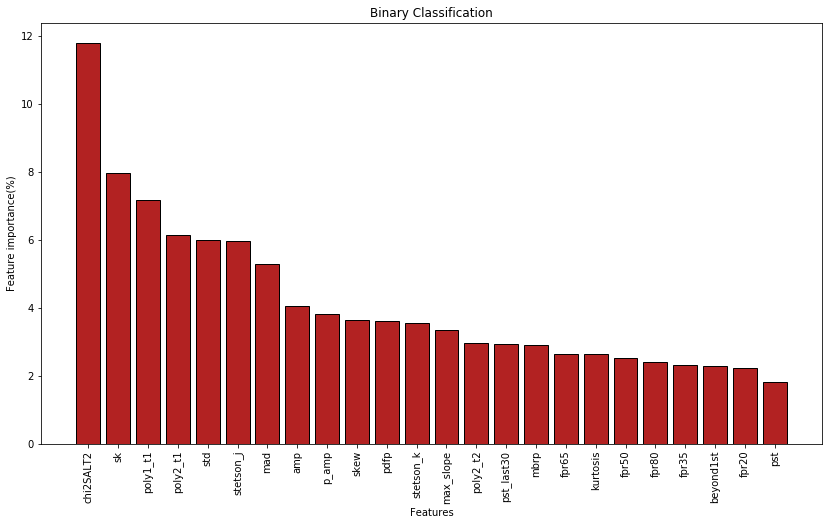

In [52]:
runModel(feats)

## with polinomials

In [25]:
feats = totFeats()

In [27]:
feats = feats[:-3]
print(feats)

['skew' 'std' 'kurtosis' 'beyond1st' 'stetson_j' 'stetson_k' 'max_slope'
 'amplitude' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'percent_amplitude'
 'percent_difference_flux_percentile' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80'
 'small_kurtosis' 'pair_slope_trend_last_30' 'poly1_t1' 'poly2_t2'
 'poly2_t1' 'poly3_t3' 'poly3_t2' 'poly3_t1' 'poly4_t4' 'poly4_t3'
 'poly4_t2' 'poly4_t1']


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8683815648445874, precision=0.8694088101540758, recall=0.8683815648445874, f1_score=0.8682900006511215, total=   6.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8623499142367067, precision=0.8632959277943489, recall=0.8623499142367067, f1_score=0.862260246513884, total=   7.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=0.8712754555198285, precision=0.872459279135222, recall=0.8712754555198285, f1_score=0.8711730897397234, total=  29.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


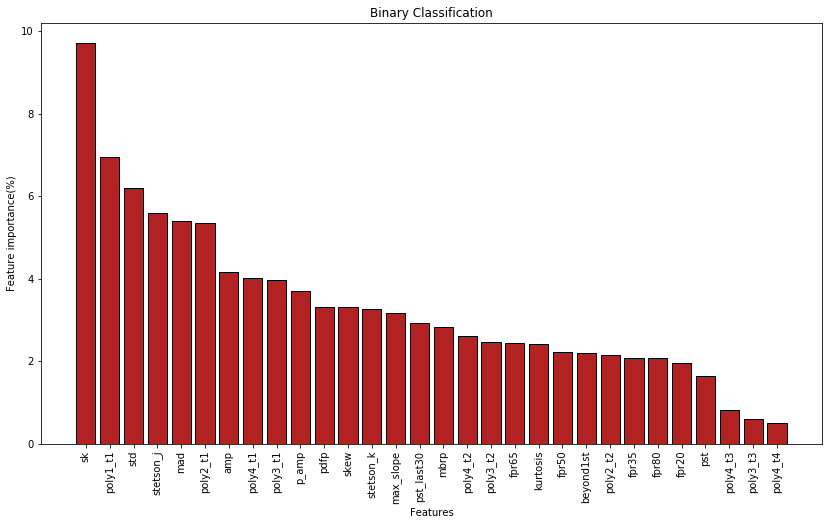

In [28]:
runModel(feats)

## polys and skew 

['skew', 'std', 'kurtosis', 'beyond1st', 'stetson_j', 'stetson_k', 'max_slope', 'amplitude', 'median_absolute_deviation', 'median_buffer_range_percentage', 'pair_slope_trend', 'percent_amplitude', 'percent_difference_flux_percentile', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'small_kurtosis', 'pair_slope_trend_last_30', 'poly1_t1', 'poly2_t2', 'poly2_t1', 'poly3_t3', 'poly3_t2', 'poly3_t1', 'poly4_t4', 'poly4_t3', 'poly4_t2', 'poly4_t1', 'chi2sGauss']
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8780278670953912, precision=0.8796829480064509, recall=0.8780278670953912, f1_score=0.8778947995007385, total=   8.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 ......

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


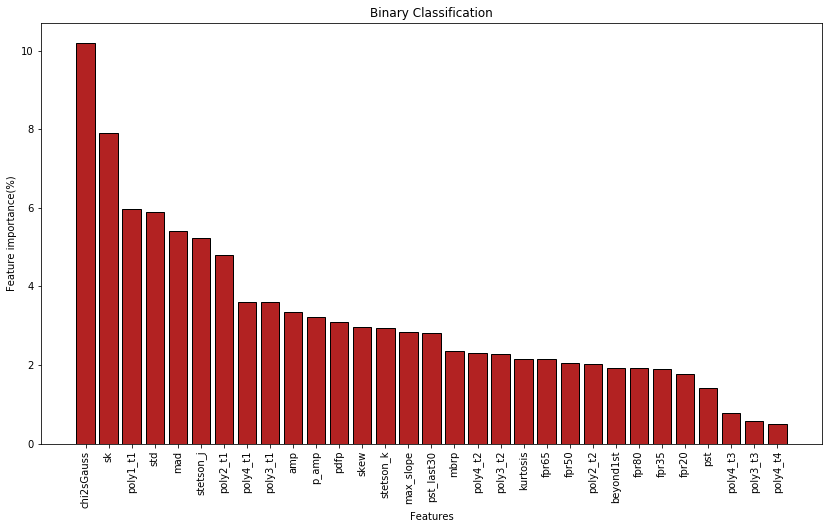

In [39]:
feats = list(totFeats())
feats.pop(-3)
feats = feats[:-1]
print(feats)
runModel(feats)

## polys and salt


['skew', 'std', 'kurtosis', 'beyond1st', 'stetson_j', 'stetson_k', 'max_slope', 'amplitude', 'median_absolute_deviation', 'median_buffer_range_percentage', 'pair_slope_trend', 'percent_amplitude', 'percent_difference_flux_percentile', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'small_kurtosis', 'pair_slope_trend_last_30', 'poly1_t1', 'poly2_t2', 'poly2_t1', 'poly3_t3', 'poly3_t2', 'poly3_t1', 'poly4_t4', 'poly4_t3', 'poly4_t2', 'poly4_t1', 'chi2Salt2']
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8810289389067524, precision=0.8819574077038325, recall=0.8810289389067524, f1_score=0.8809565957055496, total=   7.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .......

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


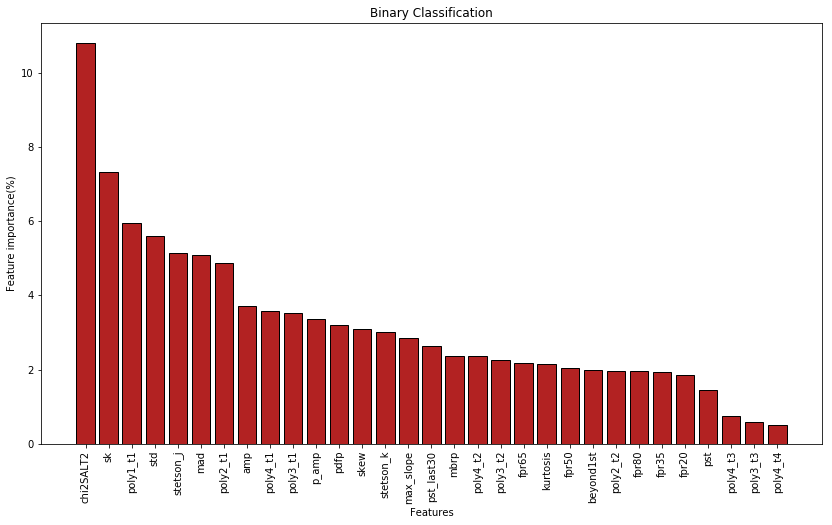

In [40]:
feats = list(totFeats())
feats.pop(-3)
feats.pop(-2)
# feats = feats[:-1]
print(feats)
runModel(feats)

## polys and both X^2

['skew', 'std', 'kurtosis', 'beyond1st', 'stetson_j', 'stetson_k', 'max_slope', 'amplitude', 'median_absolute_deviation', 'median_buffer_range_percentage', 'pair_slope_trend', 'percent_amplitude', 'percent_difference_flux_percentile', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'small_kurtosis', 'pair_slope_trend_last_30', 'poly1_t1', 'poly2_t2', 'poly2_t1', 'poly3_t3', 'poly3_t2', 'poly3_t1', 'poly4_t4', 'poly4_t3', 'poly4_t2', 'poly4_t1', 'chi2sGauss', 'chi2Salt2']
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=0.8854233654876742, precision=0.8868269094542223, recall=0.8854233654876742, f1_score=0.8853193400538086, total=   9.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
[CV] max_features=auto, n_estimato

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


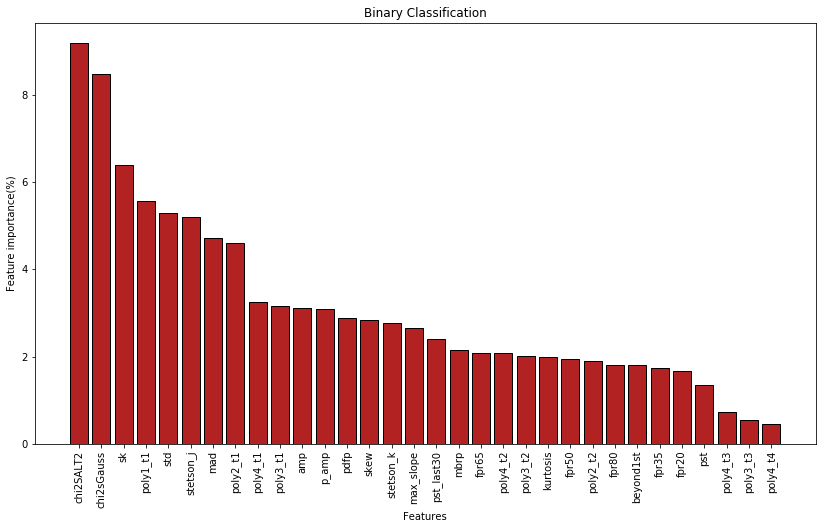

In [41]:
feats = list(totFeats())
feats.pop(-3)
# feats.pop(-2)
# feats = feats[:-1]
print(feats)
runModel(feats)